# Imports

In [1]:
import os
import re

import emoji
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', 100) 

# Read Data

In [2]:
ch_sample_link = '/data/ch_sample_selections_data.csv'
cg_sample_link = '/data/sample_wsb_gme_personalfin_stock.csv'
rr_sample_link = '/data/forex_finance_finindependence_forex.csv'

file_links = [ch_sample_link, cg_sample_link, rr_sample_link]

In [3]:
ch_sample = pd.read_csv(os.getcwd() + ch_sample_link)
cg_sample = pd.read_csv(os.getcwd() + cg_sample_link)
rr_sample = pd.read_csv(os.getcwd() + rr_sample_link)

In [4]:
print(ch_sample.shape, cg_sample.shape, rr_sample.shape)

(15000, 25) (16000, 25) (6104, 25)


In [5]:
# datatypes match
pd.concat([ch_sample.dtypes,cg_sample.dtypes,rr_sample.dtypes],axis=1)

,0,1,2
Unnamed: 0,int64,int64,int64
id,object,object,object
author,object,object,object
created,object,object,object
retrieved,object,object,object
edited,object,object,object
pinned,int64,int64,int64
archived,int64,int64,int64
locked,int64,int64,int64
removed,int64,int64,int64


In [6]:
def read_files(file_links):
    df = pd.DataFrame()
    for link in file_links:
        df = pd.concat((df, pd.read_csv(os.getcwd() + link)), axis=0)
    return df

In [7]:
df_full_raw = read_files(file_links)

In [8]:
np.random.seed(42)
indices = np.arange(len(df_full_raw))
shuffled_indices = np.random.permutation(indices)

df_full = df_full_raw.iloc[shuffled_indices]
df = df_full.copy()

# Examine Data for Cleaning

In [9]:
df.shape

(37104, 25)

In [10]:
df.isna().sum()

Unnamed: 0                  0
id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          9082
upvote_ratio                0
score                       0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    1
thumbnail                   0
shortlink                   0
dtype: int64

In [11]:
df.shape

(37104, 25)

In [12]:
df.dropna(subset='score').shape

(37104, 25)

### Dropping Null selftext values

In [13]:
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)

(37104, 25)
(37103, 25)


### Filling NA's for link_flair_text

In [14]:
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
5267,8556,qerbhk,alcesalcesalces,2021-10-24 12:36:04,2021-10-24 21:16:45,1970-01-01 00:00:00,0,0,0,0,...,,0.93,231,0,0,100,0,# Intro\n\nA very common question in the daily discussion thread is whether to accelerate paymen...,self,https://redd.it/qerbhk
13586,3586,qzuwc8,OhWowMuchFunYouGuys,2021-11-22 20:26:12,2021-11-23 04:05:45,1970-01-01 00:00:00,0,0,0,0,...,,0.78,5,0,0,5,0,https://www.fool.com/investing/2021/11/22/why-shares-of-zymergen-are-skyrocketing-today/\n\n\nTh...,self,https://redd.it/qzuwc8


In [15]:
df.describe()

,Unnamed: 0,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
count,37103.000000,37103.0,37103.0,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000,37103.000000
mean,62921.779964,0.0,0.0,0.001348,0.017573,0.014878,0.985122,0.000108,0.003046,0.777643,93.128103,0.023664,0.761475,67.770612,0.068485
std,133301.310910,0.0,0.0,0.036685,0.131394,0.121064,0.121064,0.010383,0.055103,0.198820,1194.726751,0.608309,8.956003,1055.384714,0.520844
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2136.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.670000,1.000000,0.000000,0.000000,3.000000,0.000000
50%,4349.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.820000,5.000000,0.000000,0.000000,8.000000,0.000000
75%,63041.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.950000,18.000000,0.000000,0.000000,21.000000,0.000000
max,774958.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,138766.000000,108.000000,661.000000,95717.000000,48.000000


Remove the "Unnamed: 0" field

In [16]:
df.iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
4634,143064,mefr76,AZPhotographer13,2021-03-27 15:17:21,2021-03-27 21:28:09,1970-01-01 00:00:00,0,0,0,0,...,Discussion,0.75,2,0,0,6,0,Hypothetically if you have a 500c that expires april 9th better to let it ride out or sell it fo...,self,https://redd.it/mefr76
8919,3919,qcs2dn,capex-,2021-10-21 13:40:44,2021-10-21 21:25:53,1970-01-01 00:00:00,0,0,0,0,...,Resources,0.33,0,0,0,0,0,Junior Miners are mostly held by individual investors and less likely to be held by institutions...,self,https://redd.it/qcs2dn


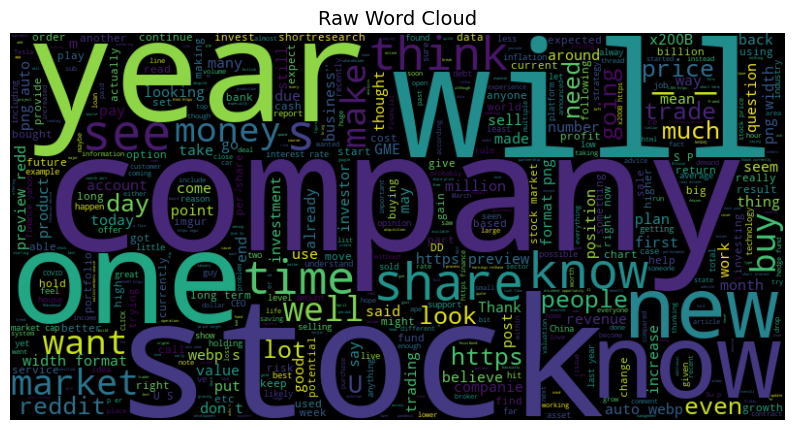

In [17]:
plt.figure(figsize=(10, 10))
words = " ".join(df['selftext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Reviewing unexpected terms, such as https, webp, pgn.

Where are these words coming from?

In [18]:
search_terms = [r'https', r'webp','png']

The search terms are all part of url's. They will be removed.

In [19]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].iloc[0]

'Junior Miners are mostly held by individual investors and less likely to be held by institutions because institutions make most decisions based upon financials and individual investors make more decisions based upon emotions. Juniors can be very risky as they are typically looking to simply discovery a mine producing resource which a profitable miner can be built upon. \n\nTherefore, when looking at juniors it is important to analyze risk and junior diversification. It is much better to have a junior working on several properties rather than one, working in existing mining districts vs unknown, and working in a politically stable nation. Those are three ways to reduce risk on any junior mining investment. Some investors may be interested in short videos online that often touch upon these topics of risk reduction:  [6 Minute CEO - YouTube](https://www.youtube.com/playlist?list=PLSRx1whFdalH-fEWKAcBfnczPtseB6agS) \n\nAs most things go, high risk = higher upside. \n\nHave you ever invest

In [20]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

'Junior Miners are mostly held by individual investors and less likely to be held by institutions because institutions make most decisions based upon financials and individual investors make more decisions based upon emotions. Juniors can be very risky as they are typically looking to simply discovery a mine producing resource which a profitable miner can be built upon. \n\nTherefore, when looking at juniors it is important to analyze risk and junior diversification. It is much better to have a junior working on several properties rather than one, working in existing mining districts vs unknown, and working in a politically stable nation. Those are three ways to reduce risk on any junior mining investment. Some investors may be interested in short videos online that often touch upon these topics of risk reduction:  [6 Minute CEO - YouTube](<url>) \n\nAs most things go, high risk = higher upside. \n\nHave you ever invested in a junior miner? What do you look for when making an investmen

Remove URL's, and replace with "< url >"

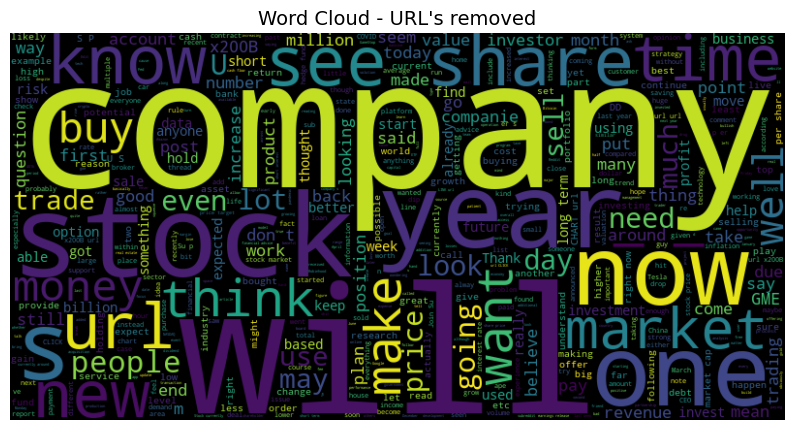

In [21]:
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [22]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['selftext'].iloc[0][:1000]

"I've always found the stock market to be overwhelming and intimidating. I have been maxing out my 401k (currently have around $80k in it) and IRA the last couple of years, but have not done any investing outside of that and was content to put everything else in a HYSA and just let it sit there.\n\n**About me:**\n\n* 26, no kids, no spouse\n* No debt\n* $180k in savings\n* $85k salary\n\nIn terms of goals, I'm really just looking to use my money smarter. I understand that investing is about the long term, while I also think some short term wins would help me get a feel for things. Only other thing is that I may want to purchase a house with my SO within the coming years.\n\nThe more I read online and in the wiki, and lurk on here and other subreddits, the more I realize I'm not making the most out of my available money. Based on what I've read, it seems that the best use/fit would be to invest in an S&P 500 ETF, either VOO or SPY, in Fidelity or Vanguard.\n\nThe prime directive and flo

In [23]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['selftext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0][:1000]

"I've always found the stock market to be overwhelming and intimidating. I have been maxing out my 401k (currently have around $80k in it) and IRA the last couple of years, but have not done any investing outside of that and was content to put everything else in a HYSA and just let it sit there.\n\n**About me:**\n\n* 26, no kids, no spouse\n* No debt\n* $180k in savings\n* $85k salary\n\nIn terms of goals, I'm really just looking to use my money smarter. I understand that investing is about the long term, while I also think some short term wins would help me get a feel for things. Only other thing is that I may want to purchase a house with my SO within the coming years.\n\nThe more I read online and in the wiki, and lurk on here and other subreddits, the more I realize I'm not making the most out of my available money. Based on what I've read, it seems that the best use/fit would be to invest in an S&P 500 ETF, either VOO or SPY, in Fidelity or Vanguard.\n\nThe prime directive and flo

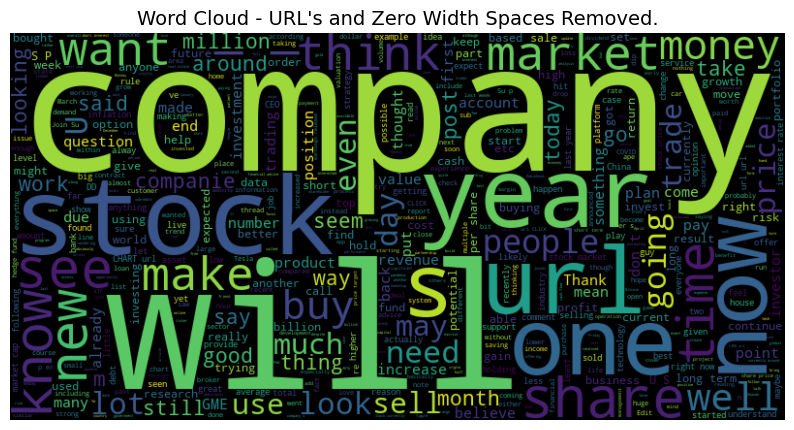

In [24]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and Zero Width Spaces Removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [25]:
df['selftext'].value_counts().iloc[:5]

selftext
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

This contains recurring discussion posts and self_text values of '[deleted]' which should be removed.

In [26]:
df.shape, df[df['selftext']!='[deleted]'].shape

((37103, 25), (36551, 25))

### Removing Discussion Posts

In [27]:
text_frequency = df['selftext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['selftext'].tolist()
df[df['selftext'].isin(discussion_posts)].iloc[:2]

,Unnamed: 0,id,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
6068,6464,r2abdd,[deleted],2021-11-26 00:18:44,2021-11-26 08:23:13,1970-01-01 00:00:00,0,0,0,1,...,NaN,1.00,1,0,0,1,0,[deleted],default,https://redd.it/r2abdd
14699,4699,lbkcln,AutoModerator,2021-02-03 10:00:14,2021-02-04 22:49:57,1970-01-01 00:00:00,0,0,0,0,...,NaN,0.93,75,0,1,1415,0,"If your question is ""I have $10,000, what do I do?"" or other ""advice for my personal situation"" ...",self,https://redd.it/lbkcln


# Cleaning Data

### Drop NA's

In [28]:
df = df.dropna(subset='selftext')

### Fill NA's

In [29]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries

In [30]:
df = df[df['selftext']!='[deleted]']

### Remove discussion posts

In [31]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

# df = remove_discussion_posts(df)

### Preprocess data and clean data
We must remove excess HTML and other words.

In [32]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [33]:
def preprocessor(text):
    try:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                               text)
        text = (re.sub('[\W]+', ' ', text.lower()) +
                ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    text = str(text).lower()
    text = re.sub(r'#(\w+)', r'<\1>', text)
    text = re.sub(r'\n', ' ', text) # Remove /n
    text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
    text = re.sub(r'RT\s+', '', text) # Remove RT
    text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
    text = re.sub('x200B', '', text)
    return text

# There's a chance we WON'T need to convert emojis to text if the model we're using supports emojis, but this might be useful
def deemoji_text(text):
    return emoji_demojize(text)

def deemoji_text_unicode(text):
    return text.encode('unicode-escape').decode('utf-8')

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

def drop_unnamed_columns(df_orig):
    df = df_orig.copy()
    unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df_full.drop(columns=unnamed_columns)
    return df

In [34]:
df['selftext'] = df['selftext'].apply(cleaner).apply(preprocessor)

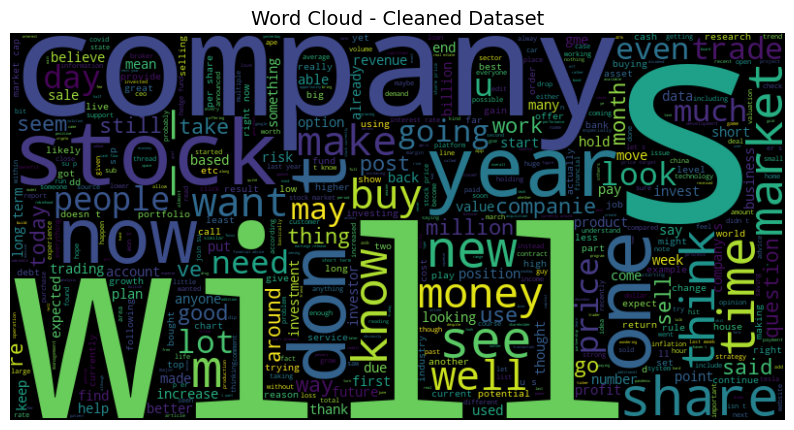

In [35]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

# Standardizing Numeric Fields

### Examine Numeric Fields

In [36]:
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
4634,0,0,0,0,0,1,0,0,0.75,2,0,0,6,0
8919,0,0,0,0,0,1,0,0,0.33,0,0,0,0,0
10390,0,0,0,0,0,1,0,0,0.77,18,0,0,17,0
11060,0,0,0,0,0,1,0,0,0.81,32,0,3,67,0
2481,0,0,0,0,0,1,0,0,0.90,17,0,1,25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,0,0,0,0,0,1,0,0,0.36,0,0,0,50,0
6265,0,0,0,0,0,1,0,0,0.55,2,0,0,18,0
11284,0,0,0,0,0,1,0,0,0.85,9,0,0,15,0
860,0,0,0,0,0,1,0,0,0.67,1,0,0,4,0


### Scale Numeric Fields

In [37]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [38]:
scaler = StandardScaler()

df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [39]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [40]:
df_std.iloc[1:3]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,selftext,thumbnail,shortlink,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
1,qcs2dn,capex-,2021-10-21 13:40:44,2021-10-21 21:25:53,1970-01-01 00:00:00,0,0,0,0,0,...,Resources,junior miners are mostly held by individual investors and less likely to be held by institutions...,self,https://redd.it/qcs2dn,-2.248485,-0.078471,-0.039195,-0.085666,-0.064680,-0.132404
2,ldxefy,Sip_py,2021-02-06 13:11:41,2021-02-07 01:17:01,2021-02-06 14:12:08,0,0,0,0,0,...,Retirement,my employer offers a retiree health reimbursement account and i also participate in a high deduc...,self,https://redd.it/ldxefy,-0.027955,-0.063517,-0.039195,-0.085666,-0.048692,-0.132404


# Full Dataset Cleaning and Training/Validation/Test Assignments

## Decisions:
 * Clean NA's
 * Clean selftext data 
    * brackets
    * URL's
 * Empty rows on the "score" column

In [41]:
df_full = df_full.dropna(subset='selftext')

In [42]:
df_full = df_full.fillna({'link_flair_text':''})

In [43]:
df_full = df_full[df_full['selftext']!='[deleted]']

In [44]:
def remove_discussion_posts(df_orig):
    '''Discussion posts are defined as posts that occur more than 3 times.'''
    df = df_orig.copy()

    text_frequency = df['selftext'].value_counts().reset_index()
    text_frequency = text_frequency[text_frequency['count']>3]
    discussion_posts = text_frequency['selftext'].tolist()
    
    df = df[~df['selftext'].isin(discussion_posts)]


    return df

In [45]:
# df = remove_discussion_posts(df)

### Clean and Preprocess Data

In [46]:
df_full['selftext'] = df_full['selftext'].apply(cleaner).apply(preprocessor)

### Drop Columns containing "Unnamed"

In [47]:
df_full = drop_unnamed_columns(df_full)

### Drop Empty selftext

In [48]:
def drop_empty_column_records(df_orig, column):
    df = df_orig.copy()
    return df[df[column]!='']

In [49]:
# df_full = drop_empty_column_records(df_full, 'selftext')

### Scale Numeric Fields

In [50]:
def scale_numeric_fields(scaler, df, scaling_fields):
    non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

    df_scaled_values = scaler.fit_transform(df[scaling_fields].values)
    df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)
    df_scaled = df_scaled.add_suffix('_std', axis=1)

    df_std = pd.concat((df.reset_index(drop=True), df_scaled), axis=1)
    
    return df_std

In [51]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

scaler = StandardScaler()

df_full = scale_numeric_fields(scaler, df_full, scaling_fields)

In [52]:
df_full.iloc[:5]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,num_crossposts,selftext,thumbnail,shortlink,upvote_ratio_std,score_std,gilded_std,total_awards_received_std,num_comments_std,num_crossposts_std
0,mefr76,AZPhotographer13,2021-03-27 15:17:21,2021-03-27 21:28:09,1970-01-01 00:00:00,0,0,0,0,0,...,0,hypothetically if you have a 500c that expires april 9th better to let it ride out or sell it fo...,self,https://redd.it/mefr76,-0.128889,-0.076810,-0.039195,-0.085666,-0.059037,-0.132404
1,qcs2dn,capex-,2021-10-21 13:40:44,2021-10-21 21:25:53,1970-01-01 00:00:00,0,0,0,0,0,...,0,junior miners are mostly held by individual investors and less likely to be held by institutions...,self,https://redd.it/qcs2dn,-2.248485,-0.078471,-0.039195,-0.085666,-0.064680,-0.132404
2,ldxefy,Sip_py,2021-02-06 13:11:41,2021-02-07 01:17:01,2021-02-06 14:12:08,0,0,0,0,0,...,0,my employer offers a retiree health reimbursement account and i also participate in a high deduc...,self,https://redd.it/ldxefy,-0.027955,-0.063517,-0.039195,-0.085666,-0.048692,-0.132404
3,lg3zvn,ImBadAtThis1,2021-02-09 14:05:35,2021-02-10 06:25:57,2021-02-09 19:00:26,0,0,0,0,0,...,0,i ve always found the stock market to be overwhelming and intimidating i have been maxing out my...,self,https://redd.it/lg3zvn,0.173911,-0.051885,-0.039195,0.246826,-0.001667,-0.132404
4,lcu2cc,Figur3z,2021-02-04 23:58:17,2021-02-05 00:59:43,1970-01-01 00:00:00,0,0,0,0,0,...,0,new ceo seems to be organizing shit with the bronco mach e and today s announcement of 29 billio...,self,https://redd.it/lcu2cc,0.628110,-0.064348,-0.039195,0.025164,-0.041168,-0.132404


### Split Data into Train, Validation, Test sets

In [53]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink',
           'upvote_ratio_std', 'score_std', 'gilded_std', 'total_awards_received_std',
           'num_comments_std', 'num_crossposts_std']]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0])
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [54]:
X_train.to_csv('./data/final/X_train.csv', index=False)
y_train.to_csv('./data/final/y_train.csv', index=False)
X_val.to_csv('./data/final/X_val.csv', index=False)
y_val.to_csv('./data/final/y_val.csv', index=False)
X_test.to_csv('./data/final/X_test.csv', index=False)
y_test.to_csv('./data/final/y_test.csv', index=False)